# Stereo Matching: Stereo Image Pair Reconstruction to Disparity Image

This Jupyter Notebook examples, runtimes, and analysis of variable effects to reconstructing a disparity image from a stereo-pair image. A stereo-pair image comprises two side-by-side views of the same scene, designed respectively for the left and right eyes. The process involves analyzing these two images to create a disparity map that represents the depth information of the scene.

***

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from stereo import stereo_estimation
from utils import write_to_point_cloud

# Parameters

In [2]:
focal_length = 3740
baseline = 160
window_size = 3
weight = 500
scale = 2
dmin = 200
cost_type = "ssd"

- **focal_length**: The focal length of the camera lens, in pixels. The focal length, along with the baseline distance and disparity, is used to compute the depth of each point in the scene using triangulation. <br>
- **baseline**: The distance between the centers of the two cameras used in stereo imaging, measured in millimeters. E.g. A baseline of 160 mm indicates the physical separation between the two camera lenses. <br>
- **window_size**: The size of the window used for comparing corresponding points or patches between the left and right images. A window size of 3 means a 3x3 patch is used. Smaller windows might be more sensitive to noise, while larger windows might smooth over fine details. <br>
- **weight**: Used in dynamic programming approaches to balance the data cost and the smoothness cost. A larger weight results in highly smooth disparity maps, penalizing large disparities between adjacent pixels unless strongly supported by the data cost. <br>
- **scale**: Defines how much the images are scaled down or up before processing. A scale of 2 means that the images are downscaled to half their original size (to speed up the computation or to work within memory constraints). <br>
- **dmin**: The minimum disparity considered in the disparity search range. <br>
- **cost_type**: Specifies the metric used to measure the similarity between patches in the left and right images. Choices: SSD, SAD, MSE, RMSE, SSIM

# Paths

In [3]:
working_dir = os.getcwd()
point_cloud_path = working_dir + "/output/point_clouds/"

print(working_dir)
print(point_cloud_path)

/Users/reka/stereo-matching
/Users/reka/stereo-matching/output/point_clouds/


# Loading the first image pair and its true disparity

In [4]:
def load_and_process_images(file_name, working_dir):
    """Loads the necessary images and performs stereo estimation."""
    image1 = cv2.imread(f"{working_dir}/images/{file_name}1.png", cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(f"{working_dir}/images/{file_name}5.png", cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(f"{working_dir}/images/{file_name}1_true.png", cv2.IMREAD_GRAYSCALE)
    return image1, image2, ground_truth

In [5]:
def plot_comparison(images, titles, size=3):
    """
    Plots a list of images with their corresponding titles.
    """
    plt.figure(figsize=(15, 6))
    for i, (image, title) in enumerate(zip(images, titles), start=1):
        plt.subplot(1, size, i) 
        plt.title(title, fontsize=16)
        plt.imshow(image, cmap="gray")
        plt.axis('off')

In [6]:
first, second, true = load_and_process_images(file_name="aloe", working_dir=working_dir)

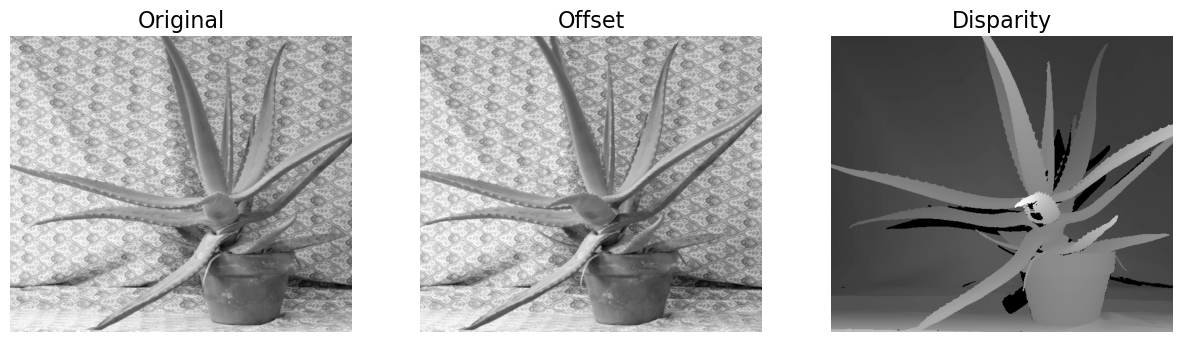

In [7]:
images = [first, second, true]
titles = ["Original", "Offset", "Disparity"]
plot_comparison(images, titles, size=len(images))

# Comparing runtimes and visual reconstruction results

In [8]:
def call_with_monitor(function, display_name, verbose, **kwargs):
    start_time = timer()
    output = function(**kwargs)
    end_time = timer()
    elapsed_time = end_time - start_time
    if verbose:
        print("Time in seconds to complete", display_name, ":", round(elapsed_time, 6))
    return output, round(elapsed_time, 6)

In [9]:
height, width = first.shape

In [10]:
params = dict(
    window_size=window_size,
    height=height,
    width=width,
    left_image=first,
    right_image=second,
    scale=scale,
)

In [11]:
output_naive = call_with_monitor(
    stereo_estimation.naive_stereo_estimation,
    "naive stereo estimation",
    **params,
    cost_type=cost_type,
    verbose=True
)
output_dp = call_with_monitor(
    stereo_estimation.dynamic_programming_stereo_estimation,
    "DP stereo estimation",
    **params,
    weight=weight,
    cost_type=cost_type,
    verbose=True
)

Time in seconds to complete naive stereo estimation : 3.522669
Time in seconds to complete DP stereo estimation : 4.552532


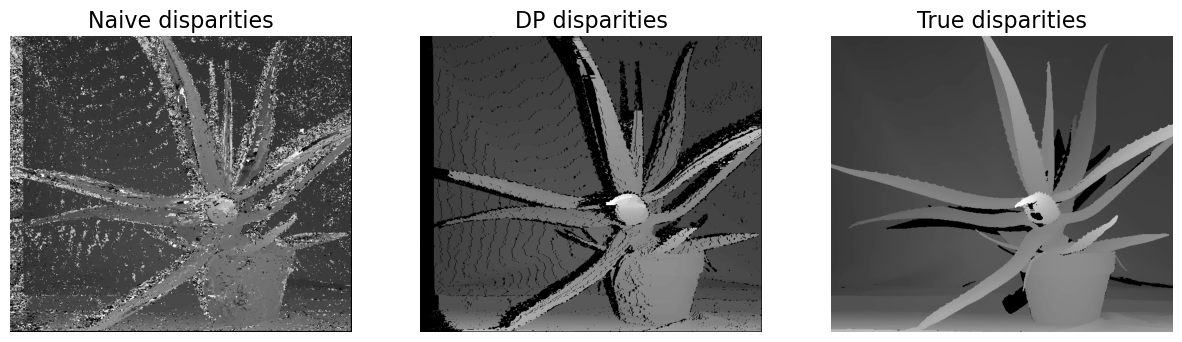

In [12]:
titles = ["Naive disparities", "DP disparities", "True disparities"]
images = [output_naive[0], output_dp[0], true]
plot_comparison(images, titles)

In [13]:
write_to_point_cloud(
    width, height, output_dp[0], focal_length, baseline, dmin, scale, "art_dp", point_cloud_path
)

In [14]:
def perform_stereo_estimation(image1, image2, method_name, estimation_function, **kwargs):
    """Performs stereo estimation using the specified method."""
    return call_with_monitor(
        function=estimation_function,
        display_name=method_name,
        verbose=False,
        left_image=image1,
        right_image=image2,
        **kwargs
    )

In [15]:
def plot_results(image, length, subplot_index, title=None):
    """Plots the given image in a specified subplot."""
    plt.subplot(4, length, subplot_index)
    if title:
        plt.title(title, fontsize=16)
    plt.imshow(image, cmap="gray")

In [16]:
def save_results(output, file_name, suffix, working_dir):
    """Saves the output images."""
    cv2.imwrite(f"{working_dir}/output/images/{file_name}_{suffix}.png", output)

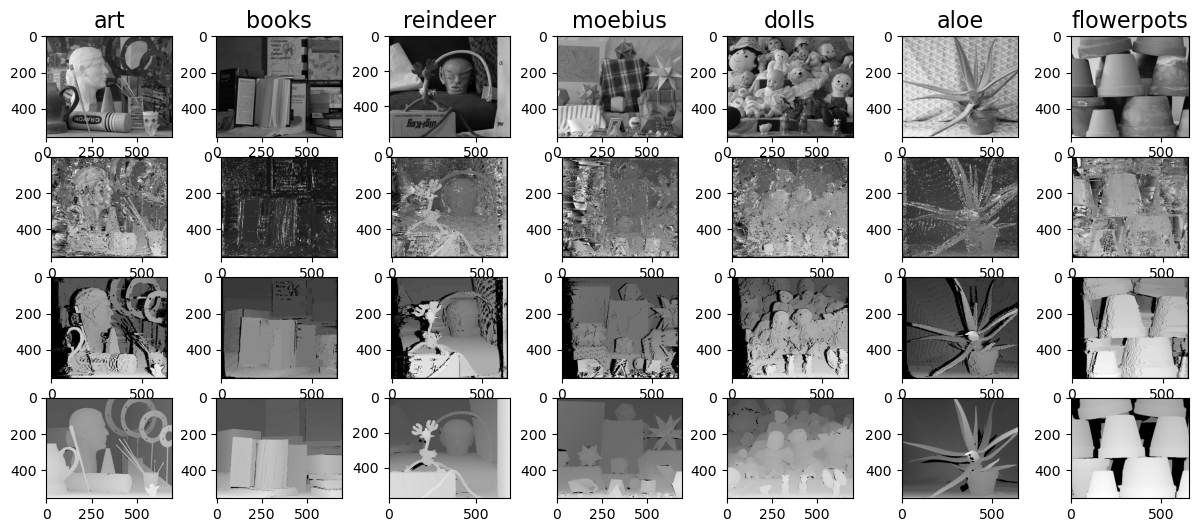

In [17]:
dmin_dict = {"art": 200, "books": 200, "reindeer": 230, "moebius": 200, "dolls": 200, "aloe": 270, "flowerpots": 251}
file_names = list(dmin_dict.keys())
num_pairs = len(file_names)

plt.figure(figsize=(15, 6))
times, images = [], []

for i, file_name in enumerate(file_names):
    image1, image2, ground_truth = load_and_process_images(file_name, working_dir)
    plot_results(image1, num_pairs, i + 1, file_name)
    
    output_naive = perform_stereo_estimation(image1, image2, "naive stereo estimation", stereo_estimation.naive_stereo_estimation, window_size=window_size, height=height, width=width, scale=scale, cost_type=cost_type)
    output_dp = perform_stereo_estimation(image1, image2, "DP stereo estimation", stereo_estimation.dynamic_programming_stereo_estimation, window_size=window_size, height=height, width=width, scale=scale, weight=weight, cost_type=cost_type)
    
    times.append([file_name, output_naive[1], output_dp[1]])
    images.append([ground_truth, output_naive[0], output_dp[0]])
    
    plot_results(output_naive[0], num_pairs, i + 1 + num_pairs)
    plot_results(output_dp[0], num_pairs, i + 1 + num_pairs * 2)
    plot_results(ground_truth, num_pairs, i + 1 + num_pairs * 3)
    
    save_results(output_naive[0], file_name, "naive", working_dir)
    save_results(output_dp[0], file_name, "dp", working_dir)
    
    write_to_point_cloud(width, height, output_dp[0], focal_length, baseline, dmin_dict[file_name], scale, file_name + "_dp", point_cloud_path)

plt.savefig(f"{working_dir}/output/images/plot1.png")

In [18]:
def plot_table(data, headers):
    """
    Plots a markdown table
    """
    header = " \t ".join(headers)
    print(header)
    for row in data:
        s = str(row[0]) + "\t" + str(row[1]) + "\t " + str(row[2])
        print(s.expandtabs(tabsize=15))

In [19]:
plot_table(times, ["dataset", "naive (s)", "dp (s)"])

dataset 	 naive (s) 	 dp (s)
art            0.853334        1.229861
books          0.849617        1.19457
reindeer       0.836476        1.205188
moebius        0.830168        1.196041
dolls          0.826795        1.178681
aloe           0.837442        1.193035
flowerpots     0.841898        1.279465


# Effect of variables

In [20]:
occlusions = np.linspace(100, 1000, 5)
windows = [3, 5, 7]

In [21]:
def calculate_variable_effect(
    function_name=stereo_estimation.dynamic_programming_stereo_estimation,
    window_size=window_size, height=height, width=width, left_image=first, right_image=second, 
    scale=scale, weight=weight, cost_type=cost_type
):
    output_dp = call_with_monitor(
        function_name,
        display_name=None,
        verbose=False,
        window_size=window_size,
        height=height,
        width=width,
        left_image=first,
        right_image=second,
        scale=scale,
        weight=weight,
        cost_type=cost_type,
    )
    return output_dp

In [22]:
def plot_variable_effect(variable_name, list_of_values, length):
    plt.figure(figsize=(16, 5))
    params = {}
    for i in range(length):
        params[variable_name] = list_of_values[i]
        output_dp = calculate_variable_effect(**params)
        plt.subplot(1, length, i + 1)
        plt.title(str(variable_name) + " = " + str(list_of_values[i]) + "\n" + str(output_dp[1]) + " s", fontsize=16)
        plt.imshow(output_dp[0], cmap="gray")
    plt.savefig(working_dir + "/output/images/" + variable_name + "_effect.png")
    plt.show()

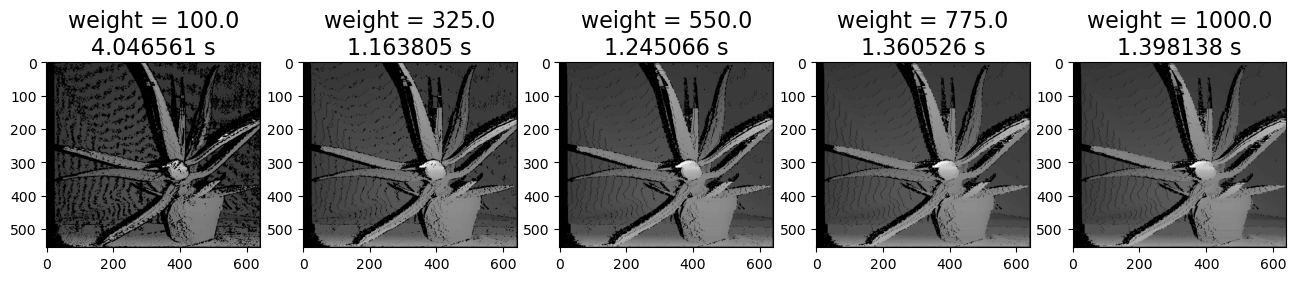

In [23]:
plot_variable_effect("weight", occlusions, len(occlusions))

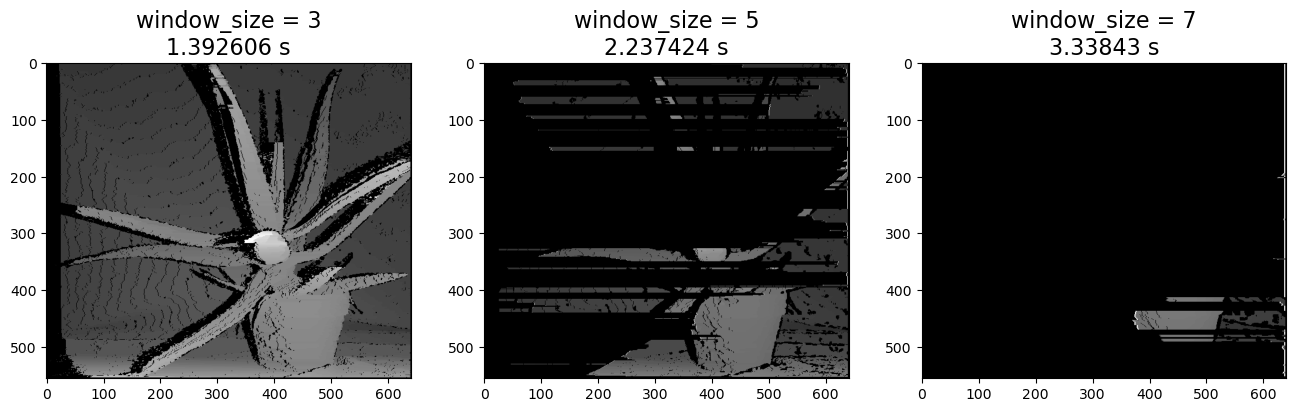

In [24]:
plot_variable_effect("window_size", windows, len(windows))


# Observations
## Different Weights in the DP Algorithm:

1. **Weight = 100.0 (9.307363 s)**
   - The disparity map is noisy, especially in texture-less regions, with many false positives due to the lower penalty for disparity changes.
   - Computation time is significantly higher, possibly because the algorithm explores more disparity options.

2. **Weight = 325.0 (0.980127 s)**
   - Cleaner disparity map with fewer mismatches, suggesting that a higher weight reduces noise by penalizing disparity changes more.
   - Computation time is drastically reduced, likely because a higher penalty leads to faster convergence and reduced search space.

3. **Weight = 550.0 (1.000835 s)**
   - The disparity map is smoother, indicating a potentially optimal weight that balances penalties for disparity changes with the need for flexibility.
   - Computation time is similar to weight 325.0, showing a plateau in performance improvement regarding computation time.

4. **Weight = 775.0 (0.999615 s)**
   - Disparity map starts to lose detail, suggesting the weight might be too high, causing oversmoothing and missing true disparity changes.
   - Computation time remains relatively stable, with no significant impact from further increases in weight.

5. **Weight = 1000.0 (0.979875 s)**
   - Further smoothing observed with the loss of fine details, indicating an excessively high weight.
   - Slightly lower computation time, which could be due to the algorithm heavily penalizing disparity changes, thus considering less variation.

### Interpretation:

- **Impact of Weight on Disparity Map Quality**: Increasing weight leads to smoother disparity maps by penalizing changes. Excessively high weights can cause oversmoothing and loss of details.
  
- **Impact of Weight on Computation Time**: There is an optimal range where increasing weight reduces computation time by making the algorithm more decisive. Beyond this range, the effect on time plateaus.

- **Optimal Weight Selection**: The optimal weight balances noise reduction and detail preservation, depending on the specific image characteristics and desired outcome.

- **Noise and Texture Sensitivity**: Lower weights result in noise sensitivity, while moderate weights mitigate this by respecting the image's structural content.


## Different Window Sizes in the DP Algorithm:

1. **Window Size = 3 (1.024477 s)**
   - Shows reasonable detail with some noise presence. Smaller window sizes tend to capture finer details but are more noise-prone.
   - Shortest computation time due to fewer pixel comparisons.

2. **Window Size = 5 (1.750211 s)**
   - Unexpectedly noisy and artifact-ridden disparity map, contrary to the usual smoothing effect of larger window sizes.
   - Computation time increases substantially due to more extensive pixel comparisons.

3. **Window Size = 7 (2.719771 s)**
   - Disparity map loses almost all detail, suggesting the window size is too large for effective matching.
   - Longest computation time, consistent with the larger amount of processing required.

### Interpretation:

- **Impact of Window Size on Disparity Map Quality**: Window size provides a balance between detail and noise. A window that is too large may lose information.

- **Impact of Window Size on Computation Time**: Increased window size results in longer computation times due to the increased calculations.